In [2]:
from typing import Tuple, List, Optional
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, skew
import pandas as pd
import numpy as np

def compute_concentration_scores(
    df: pd.DataFrame,
    metric_col: str,
    group_col: str = "territory_l4_name",
    sub_group_col: str = "territory_l8_name",
    global_filter: Optional[str] = "Global",
    p_threshold: float = 10.0,
    std_weight: float = 0.3,
    skew_weight: float = 0.3,
    tail_weight: float = 0.4
) -> Tuple[pd.DataFrame, float]:
    """Compute concentration root cause scores for each L4 region."""
    global_values = df[df[group_col] != global_filter][metric_col].dropna()
    p10_global = np.percentile(global_values, p_threshold)
    global_std = np.std(global_values)

    results = []
    for region in df[group_col].unique():
        values = df[df[group_col] == region][metric_col].dropna().values
        if len(values) == 0:
            continue
        std_val = np.std(values)
        skew_val = skew(values)
        low_ratio = np.mean(values < p10_global)
        score = (
            tail_weight * (low_ratio > 0.3) +
            std_weight * (std_val > global_std) +
            skew_weight * (skew_val < -0.5)
        )
        results.append({
            "region": region,
            "mean": np.mean(values),
            "std": std_val,
            "skew": skew_val,
            "low_l8_ratio": low_ratio,
            "p10_global": p10_global,
            "score": score
        })

    return pd.DataFrame(results), p10_global

def plot_region_densities(
    df: pd.DataFrame,
    metric_col: str,
    group_col: str = "territory_l4_name",
    global_p10: Optional[float] = None,
    xrange: Tuple[float, float] = (0.35, 0.75)
):
    """Visualize density distributions per region with global percentile marker."""
    plt.figure(figsize=(10, 6))
    for region in df[group_col].unique():
        values = df[df[group_col] == region][metric_col].dropna()
        if len(values) == 0:
            continue
        density = gaussian_kde(values)
        xs = np.linspace(*xrange, 200)
        plt.plot(xs, density(xs), label=region, linewidth=2)
    if global_p10:
        plt.axvline(global_p10, color="red", linestyle="--", label="Global 10th Percentile")
    plt.title(f"Density Plot: {metric_col} by {group_col}")
    plt.xlabel(metric_col.replace("_", " ").title())
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [3]:
df = pd.read_csv("input/metrics_input/Mock_L8_CLI_Qualified_Data.csv")

In [4]:
df.head(1)

,territory_l4_name,territory_l8_name,cli_qualified_within_14d_pct
0,AM-APAC,AM-APAC_1,0.699451


In [5]:
compute_concentration_scores(df, 'cli_qualified_within_14d_pct', group_col='territory_l4_name', sub_group_col='territory_l8_name', global_filter='Global')

(     region      mean       std      skew  low_l8_ratio  p10_global  score
 0   AM-APAC  0.700264  0.010296  0.278893           0.0    0.513984    0.0
 1   AM-EMEA  0.646973  0.011929 -0.388992           0.0    0.513984    0.0
 2  AM-LATAM  0.590120  0.013979  0.667938           0.0    0.513984    0.0
 3     AM-NA  0.488395  0.054295 -1.080217           0.5    0.513984    0.7,
 0.5139840018000166)

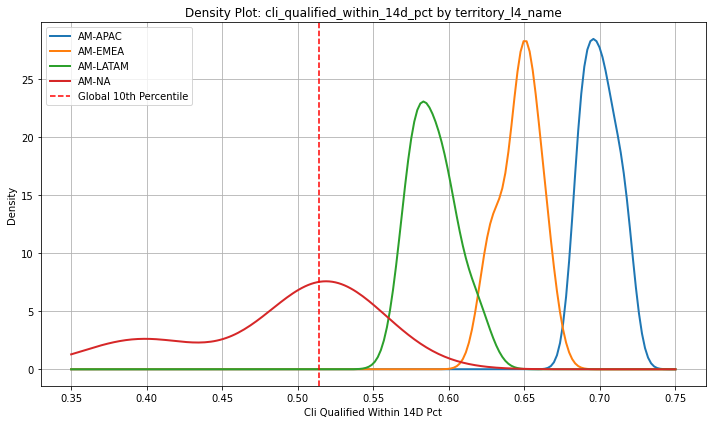

In [6]:
plot_region_densities(
    df = df,
    metric_col = 'cli_qualified_within_14d_pct',
    group_col = "territory_l4_name",
    global_p10 = compute_concentration_scores(df, 'cli_qualified_within_14d_pct', group_col='territory_l4_name', sub_group_col='territory_l8_name', global_filter='Global')[1],
    xrange = (0.35, 0.75)
)

In [1]:
import yaml

In [5]:
# Create mock closed-lost data (AM-APAC vs Global)
mock_reason_data = [
    {"region": "AM-APAC", "reason": "meta_trust_issues", "opportunity_lost": 1.5, "pct_of_total": 0.15},
    {"region": "AM-APAC", "reason": "initiative_duplication", "opportunity_lost": 1.0, "pct_of_total": 0.10},
    {"region": "AM-APAC", "reason": "Advertiser not response", "opportunity_lost": 1.1, "pct_of_total": 0.11},
    {"region": "Global", "reason": "meta_trust_issues", "opportunity_lost": 5.0, "pct_of_total": 0.05},
    {"region": "Global", "reason": "initiative_duplication", "opportunity_lost": 4.0, "pct_of_total": 0.06},
    {"region": "Global", "reason": "Advertiser not response", "opportunity_lost": 3.5, "pct_of_total": 0.04}
]
mock_df = pd.DataFrame(mock_reason_data)

# Load the tag YAML we just created
with open("../config/closed_lost_reason_tags.yaml") as f:
    reason_yaml = yaml.safe_load(f)

# Generate insights from mock data using that YAML
mock_merged = mock_df.pivot(index="reason", columns="region", values="pct_of_total").reset_index()
mock_merged["delta"] = mock_merged["AM-APAC"] - mock_merged["Global"]
mock_merged["overindex_ratio"] = mock_merged["AM-APAC"] / mock_merged["Global"]
mock_merged["category"] = mock_merged["reason"].map(lambda r: reason_yaml.get(r, {}).get("category", "unknown"))
mock_merged["recommended_action"] = mock_merged["reason"].map(lambda r: reason_yaml.get(r, {}).get("potential_action", "review manually"))

# Sort for final output
mock_insight_df = mock_merged.sort_values("delta", ascending=False)

In [6]:
mock_insight_df

region,reason,AM-APAC,Global,delta,overindex_ratio,category,recommended_action
2,meta_trust_issues,0.15,0.05,0.10,3.000000,perception,Deploy leadership-led outreach and case studies
0,Advertiser not response,0.11,0.04,0.07,2.750000,engagement barrier,Set stricter requalification cutoffs; prioriti...
1,initiative_duplication,0.10,0.06,0.04,1.666667,internal misalignment,Improve initiative tracking and internal visib...


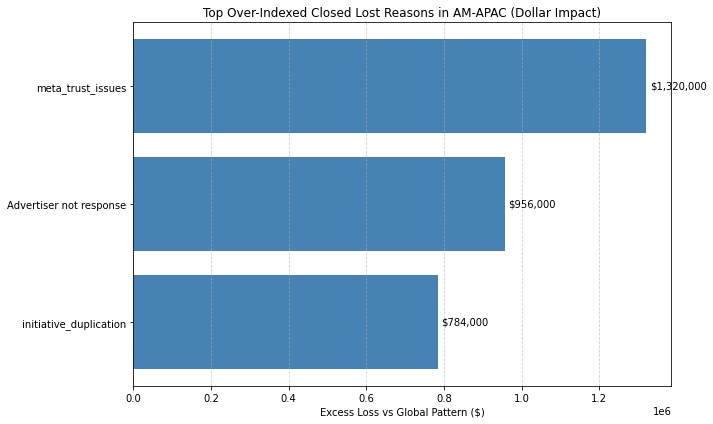

In [7]:
mock_reason_data = [
    {"region": "AM-APAC", "reason": "meta_trust_issues", "opportunity_lost": 1_500_000, "pct_of_total": 0.15},
    {"region": "AM-APAC", "reason": "initiative_duplication", "opportunity_lost": 1_000_000, "pct_of_total": 0.10},
    {"region": "AM-APAC", "reason": "Advertiser not response", "opportunity_lost": 1_100_000, "pct_of_total": 0.11},
    {"region": "Global", "reason": "meta_trust_issues", "opportunity_lost": 5_000_000, "pct_of_total": 0.05},
    {"region": "Global", "reason": "initiative_duplication", "opportunity_lost": 4_000_000, "pct_of_total": 0.06},
    {"region": "Global", "reason": "Advertiser not response", "opportunity_lost": 3_500_000, "pct_of_total": 0.04}
]
mock_df = pd.DataFrame(mock_reason_data)

# Updated RCA function
def generate_closed_lost_rca_insight(df: pd.DataFrame, reason_yaml: dict, focus_region: str, baseline_region: str = "Global") -> pd.DataFrame:
    total_opportunity = df.groupby("region")["opportunity_lost"].sum().to_dict()
    pct_pivot = df.pivot(index="reason", columns="region", values="pct_of_total").reset_index()
    val_pivot = df.pivot(index="reason", columns="region", values="opportunity_lost").reset_index()
    merged = pd.merge(pct_pivot, val_pivot, on="reason", suffixes=("_pct", "_val"))
    merged["delta_pct"] = merged[f"{focus_region}_pct"] - merged[f"{baseline_region}_pct"]
    merged["overindex_ratio"] = merged[f"{focus_region}_pct"] / merged[f"{baseline_region}_pct"]
    merged["expected_loss_at_global_pct"] = total_opportunity[focus_region] * merged[f"{baseline_region}_pct"]
    merged["excess_loss_$"] = merged[f"{focus_region}_val"] - merged["expected_loss_at_global_pct"]
    merged["category"] = merged["reason"].map(lambda r: reason_yaml.get(r, {}).get("category", "unknown"))
    merged["recommended_action"] = merged["reason"].map(lambda r: reason_yaml.get(r, {}).get("potential_action", "review manually"))
    return merged.sort_values("excess_loss_$", ascending=False)

# Run RCA
rca_result_df = generate_closed_lost_rca_insight(mock_df, reason_yaml, focus_region="AM-APAC")

# Plot
top_n = 5
top_df = rca_result_df.sort_values("excess_loss_$", ascending=True).tail(top_n)
plt.figure(figsize=(10, 6))
bars = plt.barh(top_df["reason"], top_df["excess_loss_$"], color="steelblue")
plt.xlabel("Excess Loss vs Global Pattern ($)")
plt.title("Top Over-Indexed Closed Lost Reasons in AM-APAC (Dollar Impact)")
for bar in bars:
    width = bar.get_width()
    plt.text(width + 10000, bar.get_y() + bar.get_height() / 2, f"${width:,.0f}", va='center')
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

In [8]:
# Version 2: Z-score across regions (peer-relative)
from scipy.stats import zscore

In [16]:
df = pd.read_csv("../input/metrics_input/Mock_Vertical-Region_Closed_Won_Rates.csv")

In [18]:
# Version 1: Global baseline comparison (lift-based)
def vertical_fit_lift(df: pd.DataFrame, focus_region: str = "AM-NA", baseline_region: str = "Global") -> pd.DataFrame:
    pivot = df.pivot(index="vertical", columns="region", values="cli_closed_won_pct").reset_index()
    pivot["delta"] = pivot[focus_region] - pivot[baseline_region]
    pivot["lift"] = pivot[focus_region] / pivot[baseline_region]
    return pivot.sort_values("lift", ascending=False)

def vertical_fit_zscore(df: pd.DataFrame, focus_region: str = "AM-NA") -> pd.DataFrame:
    peer_df = df[df["region"] != "Global"]
    grouped = peer_df.groupby("vertical")["cli_closed_won_pct"].transform(zscore)
    peer_df = peer_df.copy()
    peer_df["z_score"] = grouped
    return peer_df[peer_df["region"] == focus_region].sort_values("z_score", ascending=False)

# Run both analyses
lift_df = vertical_fit_lift(df)
zscore_df = vertical_fit_zscore(df)

In [19]:
lift_df

region,vertical,AM-APAC,AM-EMEA,AM-LATAM,AM-NA,Global,delta,lift
0,Pharma,0.022,0.025,0.021,0.045,0.028,0.017,1.607143
1,Retail,0.019,0.022,0.020,0.025,0.021,0.004,1.190476
2,Tech,0.021,0.020,0.018,0.018,0.022,-0.004,0.818182


In [20]:
zscore_df

,region,vertical,cli_closed_won_pct,z_score
3,AM-NA,Pharma,0.045,1.712329
8,AM-NA,Retail,0.025,1.527525
13,AM-NA,Tech,0.018,-0.962250


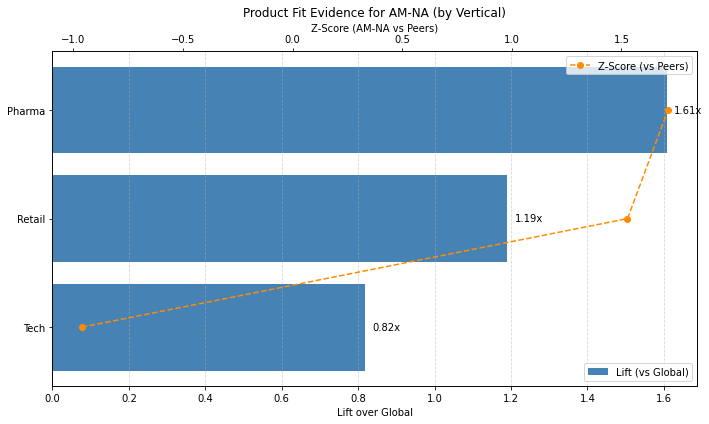

In [17]:
# Wrap product fit analysis and visualization into a reusable function
import matplotlib.pyplot as plt
from scipy.stats import zscore

def product_fit_report(df: pd.DataFrame, focus_region: str = "AM-NA", baseline_region: str = "Global"):
    # Version 1: Lift vs. global
    lift_pivot = df.pivot(index="vertical", columns="region", values="cli_closed_won_pct").reset_index()
    lift_pivot["lift"] = lift_pivot[focus_region] / lift_pivot[baseline_region]
    lift_pivot["delta"] = lift_pivot[focus_region] - lift_pivot[baseline_region]

    # Version 2: Z-score vs. regional peers (excluding Global)
    peer_df = df[df["region"] != baseline_region].copy()
    peer_df["z_score"] = peer_df.groupby("vertical")["cli_closed_won_pct"].transform(zscore)
    zscore_df = peer_df[peer_df["region"] == focus_region][["vertical", "z_score"]]

    # Merge for combined view
    result = pd.merge(lift_pivot[["vertical", "lift", "delta"]], zscore_df, on="vertical")
    result = result.sort_values("lift", ascending=True)

    # Plot
    fig, ax1 = plt.subplots(figsize=(10, 6))
    bars = ax1.barh(result["vertical"], result["lift"], color="steelblue", label="Lift (vs Global)")
    for i, (lift, z) in enumerate(zip(result["lift"], result["z_score"])):
        ax1.text(lift + 0.02, i, f"{lift:.2f}x", va="center")

    ax2 = ax1.twiny()
    ax2.plot(result["z_score"], result["vertical"], "o--", color="darkorange", label="Z-Score (vs Peers)")

    ax1.set_xlabel("Lift over Global")
    ax2.set_xlabel("Z-Score (AM-NA vs Peers)")
    ax1.set_title(f"Product Fit Evidence for {focus_region} (by Vertical)")
    ax1.grid(axis='x', linestyle='--', alpha=0.5)
    ax1.legend(loc="lower right")
    ax2.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

    return result

# Run on mock data
fit_df = product_fit_report(df)